In [7]:
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import os
import glob

# Custom imports
from utils import plot_performance_2, load_cotton_data, plot_history_2, save_history, load_history
from cnns_2 import build_model

from datetime import datetime
import seaborn as sns
#import keras
#from keras import layers

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


import keras_tuner
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.models import load_model

In [2]:
# Define the subfolder name
dataset = "dataset"
image_data = "a_normalized_twri_four_days_data_12_channels.npy"
yield_data = "yield_data_5375.npy"
new_data, yield_data = load_cotton_data(dataset, image_data, yield_data)

In [13]:
print(new_data.shape)

(5376, 32, 32, 12)


In [14]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=40,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="cotton",
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}


In [3]:
train_images, test_images, train_labels, test_labels = train_test_split(new_data, yield_data, test_size=0.2, random_state=42)

In [17]:

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(train_images, train_labels, epochs=80, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Trial 32 Complete [00h 00m 20s]
val_mae: 0.05067549645900726

Best val_mae So Far: 0.045317668467760086
Total elapsed time: 00h 12m 18s


In [18]:
tuner.results_summary()

Results summary
Results in my_dir\cotton
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 17 summary
Hyperparameters:
filters_1: 64
filters_2: 128
filters_3: 64
units: 128
Score: 0.045317668467760086

Trial 13 summary
Hyperparameters:
filters_1: 64
filters_2: 128
filters_3: 128
units: 128
Score: 0.04722614586353302

Trial 26 summary
Hyperparameters:
filters_1: 64
filters_2: 64
filters_3: 128
units: 64
Score: 0.04777580872178078

Trial 23 summary
Hyperparameters:
filters_1: 64
filters_2: 64
filters_3: 64
units: 128
Score: 0.04827877879142761

Trial 16 summary
Hyperparameters:
filters_1: 64
filters_2: 64
filters_3: 64
units: 96
Score: 0.049420442432165146

Trial 22 summary
Hyperparameters:
filters_1: 64
filters_2: 64
filters_3: 64
units: 64
Score: 0.04971984028816223

Trial 14 summary
Hyperparameters:
filters_1: 64
filters_2: 128
filters_3: 128
units: 96
Score: 0.05007246881723404

Trial 06 summary
Hyperparameters:
filters_1: 32
filters_2: 64
filters_3: 128
units:

In [19]:
best_hp = tuner.get_best_hyperparameters()[0]
model = build_model(best_hp)

In [20]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_images, train_labels, epochs=50,
                  validation_data=(test_images, test_labels),
                  callbacks=[tensorboard_callback])

Epoch 1/50
118/118 [==============================] - 2s 12ms/step - loss: 0.0525 - mae: 0.1721 - val_loss: 0.0149 - val_mae: 0.0960
Epoch 2/50
118/118 [==============================] - 1s 10ms/step - loss: 0.0134 - mae: 0.0917 - val_loss: 0.0110 - val_mae: 0.0837
Epoch 3/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0090 - mae: 0.0749 - val_loss: 0.0077 - val_mae: 0.0681
Epoch 4/50
118/118 [==============================] - 1s 10ms/step - loss: 0.0087 - mae: 0.0734 - val_loss: 0.0070 - val_mae: 0.0647
Epoch 5/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0073 - mae: 0.0671 - val_loss: 0.0128 - val_mae: 0.0903
Epoch 6/50
118/118 [==============================] - 1s 10ms/step - loss: 0.0064 - mae: 0.0626 - val_loss: 0.0127 - val_mae: 0.0919
Epoch 7/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0052 - mae: 0.0561 - val_loss: 0.0064 - val_mae: 0.0620
Epoch 8/50
118/118 [==============================] - 1s 11ms/step - 

In [21]:
model.save('customized_cnn_5376.keras')
save_history(history, 'cnn_history_5376.pkl')

In [4]:
loaded_history = load_history('cnn_history_5376.pkl')

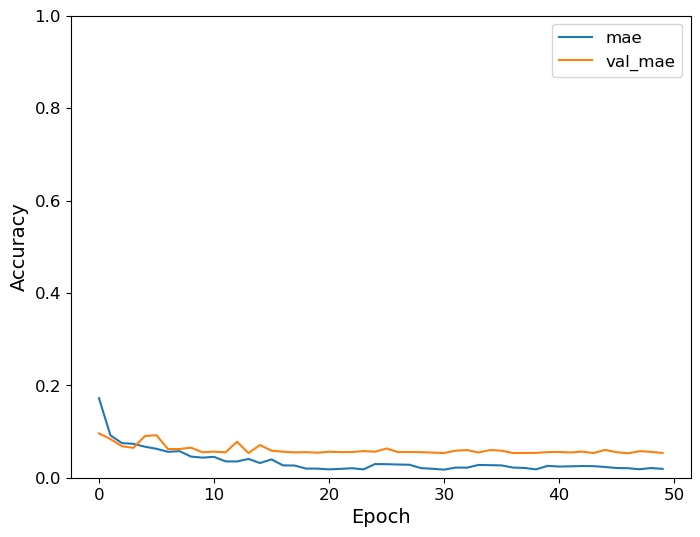

In [8]:
# plot and save the image
plot_history_2(loaded_history)

In [9]:
from tensorflow.keras.models import load_model
model = load_model('customized_cnn_5376.keras')

In [10]:
y_pred = model.predict(test_images)
# Round each element to two decimal places
y_pred_rounded = np.round(y_pred, decimals=2)
mae = mean_absolute_error(test_labels, y_pred_rounded)
print("Mean Absolute Error:", mae)

51/51 [==============================] - 0s 4ms/step
Mean Absolute Error: 0.053471792455293786


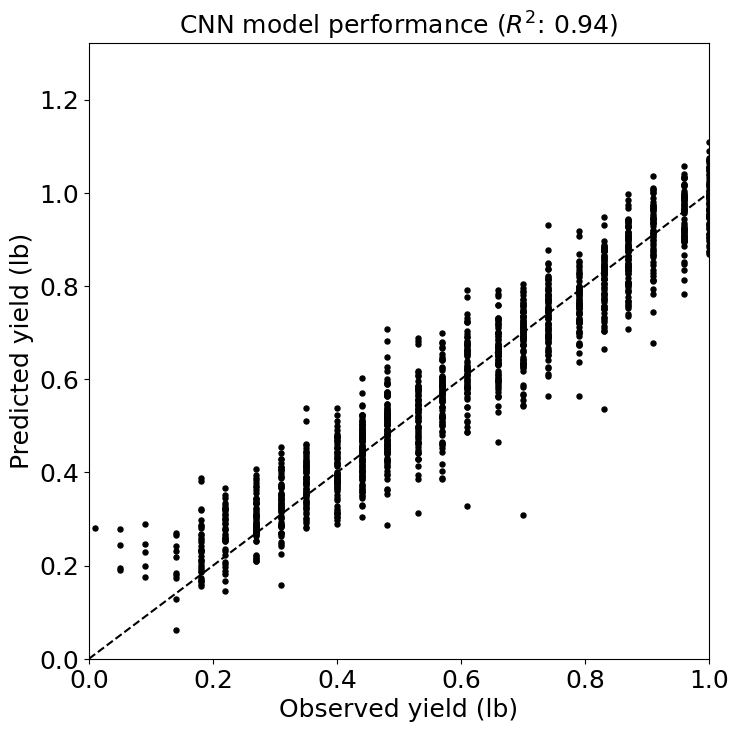

In [11]:
plot_performance_2(test_labels, y_pred, "CNN")

In [12]:
# mae, mape
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_labels, y_pred)

0.1291543536134205

In [23]:
# %load_ext tensorboard
# %tensorboard --logdir  logs